# Greek Or Not?
Can we use the nutrition facts on a yogurt cup to determine if it's Greek yogurt? In doing so, what can we learn about the health benefits of Greek yogurt vs. regular yogurt?

Author: [Kevin Fu](https://github.com/kfu02)

Created for [TJML Club] 2019-2020

In [1]:
#core data science packages
import pandas as pd
import numpy as np

#SVM models
from sklearn import svm

#graphing
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
%matplotlib inline

### Read in data
We read in the csv file with nutrition facts and turn it into a pandas dataframe.

Data compiled from a list of [most consumed brands of yogurt](https://www.statista.com/statistics/279763/us-households-most-consumed-brands-of-yogurt-or-smoothies-within-30-days/) in the US. Each brand's row is based on their vanilla yogurt's nutrition facts. All values are in grams except cholesterol and sodium, which are in milligrams.

In [2]:
nutr_facts = pd.read_csv('yogurt_nutrition_facts.csv', index_col=0)
nutr_facts

,serving_size,calories,fat,sat_fat,cholesterol,sodium,carbs,sugars,protein,greek_or_not
brand_name,,,,,,,,,,
Chobani,150,110,0.0,0,5.0,60,15,13,12,greek
Dannon,150,140,4.5,3,15.0,70,20,15,5,not
Yoplait,150,150,2.0,1,10.0,105,26,19,6,not
Yoplait_Greek,150,100,0.0,0,2.5,60,10,7,15,greek
Dannon_Oikos,150,110,0.0,0,10.0,45,16,15,12,greek
La_Yogurt,170,160,5.0,3,20.0,80,23,19,6,not
Fage,227,190,0.0,0,0.0,70,27,25,20,greek
Lala,170,150,1.5,1,10.0,95,29,24,6,not
Stonyfield,227,200,8.0,5,25.0,110,26,22,7,not


### Normalize data
The serving sizes for each brand are different; here, we normalize all nutrition facts to 150 g servings.

In [3]:
#remove last col
df = nutr_facts.drop(['greek_or_not'], axis=1) 

#divide all nums by grams of serving size
std_sz = 150
for r in range(len(df)): 
    row = df.iloc[r]
    sz = row['serving_size']
    df.iloc[r] = row.div(sz).mul(std_sz)

#add back dropped col
nutr_facts = pd.concat([df, nutr_facts['greek_or_not']], axis=1)
nutr_facts

,serving_size,calories,fat,sat_fat,cholesterol,sodium,carbs,sugars,protein,greek_or_not
brand_name,,,,,,,,,,
Chobani,150.0,110.000000,0.000000,0.000000,5.000000,60.000000,15.000000,13.000000,12.000000,greek
Dannon,150.0,140.000000,4.500000,3.000000,15.000000,70.000000,20.000000,15.000000,5.000000,not
Yoplait,150.0,150.000000,2.000000,1.000000,10.000000,105.000000,26.000000,19.000000,6.000000,not
Yoplait_Greek,150.0,100.000000,0.000000,0.000000,2.500000,60.000000,10.000000,7.000000,15.000000,greek
Dannon_Oikos,150.0,110.000000,0.000000,0.000000,10.000000,45.000000,16.000000,15.000000,12.000000,greek
La_Yogurt,150.0,141.176471,4.411765,2.647059,17.647059,70.588235,20.294118,16.764706,5.294118,not
Fage,150.0,125.550661,0.000000,0.000000,0.000000,46.255507,17.841410,16.519824,13.215859,greek
Lala,150.0,132.352941,1.323529,0.882353,8.823529,83.823529,25.588235,21.176471,5.294118,not
Stonyfield,150.0,132.158590,5.286344,3.303965,16.519824,72.687225,17.180617,14.537445,4.625551,not


### Pick features to train SVM
For this example, we'll be picking two features to train our SVM with since that's easy to visualize. In reality we could easily throw all of our features to scikit's SVM model.

Modify ```f1``` and ```f2``` (feature 1 and feature 2) to see different relationships. Anything with fat or saturated fat as one of the features will be too obvious, since Greek yogurt tends to have 0 fat. Good pairs to try: *cholesterol v calores, cholesterol v sugars,* and *calories v sugars.*

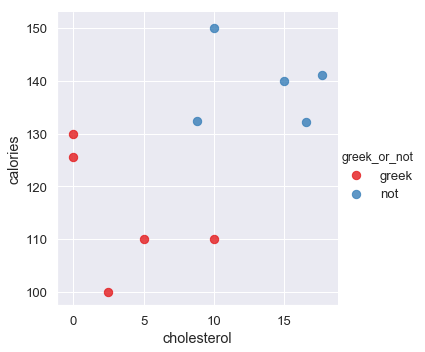

In [4]:
#change these variables
f1 = 'cholesterol'
f2 = 'calories'

sns.lmplot(x=f1, y=f2, data=nutr_facts, hue='greek_or_not',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70});

### Construct model
We extract the input data for our SVM from the selected features. The output data is converted from strings to numbers: ```{'greek':1, 'not':0}```

In [5]:
#define input feats
input_features = nutr_facts[[f1, f2]].values
classes = np.where(nutr_facts['greek_or_not']=='not',0,1)

#fit SVM model
model = svm.SVC(kernel='linear')
model.fit(input_features, classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Visualize the SVM
This section heavily borrows from [this jupyter notebook](https://github.com/adashofdata/muffin-cupcake/blob/master/muffin_vs_cupcake_demo.ipynb). We're just taking the boundary hyperplane from the SVM trained and displaying it with its margins to the support vectors.

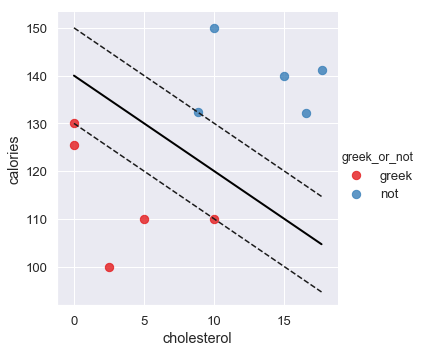

In [6]:
# Get the separating hyperplane
w = model.coef_[0]
a = -w[0] / w[1]
#fit to min/max values on x-axis
xx = np.linspace(np.amin(input_features[:,0]), np.amax(input_features[:,0]))
yy = a * xx - (model.intercept_[0]) / w[1]

# Plot the parallels to the separating hyperplane that pass through the support vectors
b = model.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = model.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# Look at the margins and support vectors
sns.lmplot(x=f1, y=f2, data=nutr_facts, hue='greek_or_not',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70});plt.plot(xx, yy, linewidth=2, color='black')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            s=80, facecolors='none');

### Predict with the SVM
Finally, we can use the model to predict whether other cups with a given nutrition label are greek or not.

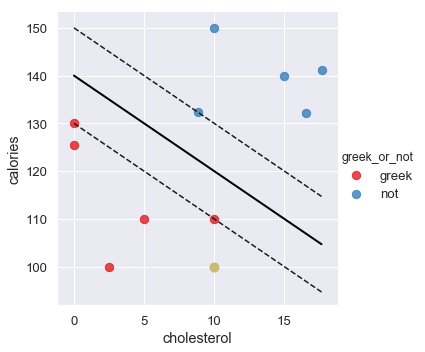

In [7]:
#create new fake yogurt nutrition facts
yoplay = [150, 100, 2.0, 1, 10.0, 105, 26, 19, 6]
feats = list(nutr_facts.keys())
yoplay_x, yoplay_y = yoplay[feats.index(f1)], yoplay[feats.index(f2)]

#visualize new plot
sns.lmplot(x=f1, y=f2, data=nutr_facts, hue='greek_or_not',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70});plt.plot(xx, yy, linewidth=2, color='black')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            s=80, facecolors='none');
plt.plot(yoplay_x, yoplay_y, 'yo', markersize='9');

In [8]:
#final answer
answer = "not" if model.predict([[yoplay_x, yoplay_y]]) == 0 else "greek"
answer

'greek'